In [36]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

In [2]:
orgs = pd.read_csv("org_feature_engagement.csv")

In [26]:
q = '''select
            org,
            date_trunc('month', date) as month,
            sum(amount) as vol
        from transactions
        where status='A' and date>=2018
        group by org, date_trunc('month', date)'''
trans = redshift_query_read(q)
trans = trans[trans['org']!=0]

q = '''select
            org,
            date_trunc('month', date) as month,
            count(id) as count
        from transactions
        where status='A' and date>=2018 and recurring=0
        group by org, date_trunc('month', date)'''
trans_count = redshift_query_read(q)
trans_count = trans_count[trans_count['org']!=0]

trans = trans.merge(trans_count, on=['org', 'month'], how='outer').fillna(0)

In [5]:
q = '''select
            org,
            date_trunc('month', date) as month,
            sum(views) as pageviews
        from googleanalytics_traffic
        where date>=2018
        group by date_trunc('month', date), org'''
pageviews = redshift_query_read(q)
pageviews = pageviews[pageviews['org']!=0]

In [27]:
perf = trans.merge(pageviews, on=['org', 'month'], how='outer').fillna(0)
perf['conversion'] = perf['count'] / perf['pageviews']
perf.tail()

,org,month,vol,count,pageviews,conversion
88247,443071,2019-11-01,0.0,0.0,2.0,0.0
88248,442326,2019-02-01,0.0,0.0,2.0,0.0
88249,31805,2020-10-01,0.0,0.0,1.0,0.0
88250,443591,2020-04-01,0.0,0.0,2.0,0.0
88251,441723,2020-06-01,0.0,0.0,2.0,0.0


In [41]:
len_inf_perf = len(perf[perf['conversion']==np.inf])
len_all = len(perf)
len_all, len_inf_perf, "{:.4f}".format(len_inf_perf / len_all)

(88252, 7992, '0.0906')

# performance by engagement sum

In [42]:
def get_engagement(org):
    if len(orgs[orgs['org'].astype(int)==int(org)]['engagement_sum']) > 0:
        return orgs[orgs['org'].astype(int)==int(org)]['engagement_sum'].iloc[0]
    else:
        return 0

avgs = perf[perf['conversion']!=np.inf].groupby('org')[['vol', 'count', 'conversion']].mean().reset_index()
avgs['feature_engagement'] = avgs['org'].apply(get_engagement)
avgs.head()

,org,vol,count,conversion,feature_engagement
0,6,13097.242059,99.676471,0.139747,20.0
1,9,0.204706,0.147059,0.000123,19.0
2,13,7858.786176,67.176471,0.055358,21.0
3,31,5258.405882,21.970588,0.085382,12.0
4,33,1006.697353,2.911765,0.049843,11.0


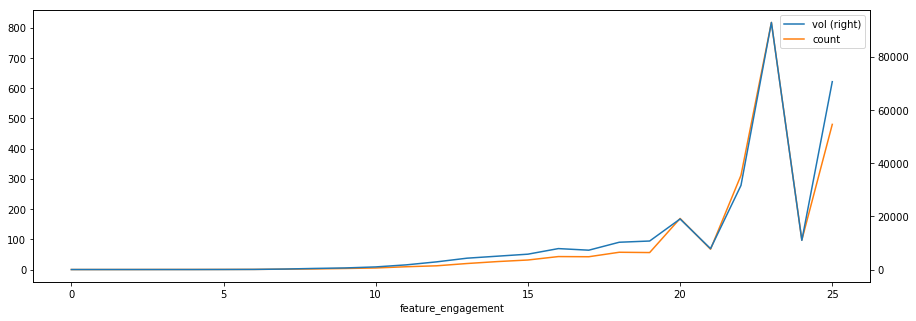

In [47]:
ax = avgs.groupby('feature_engagement')[['vol', 'count']].median().reset_index().plot(x='feature_engagement', secondary_y='vol', figsize=(15,5))
ax.figure.savefig("feature_engagement_vol_count.png")

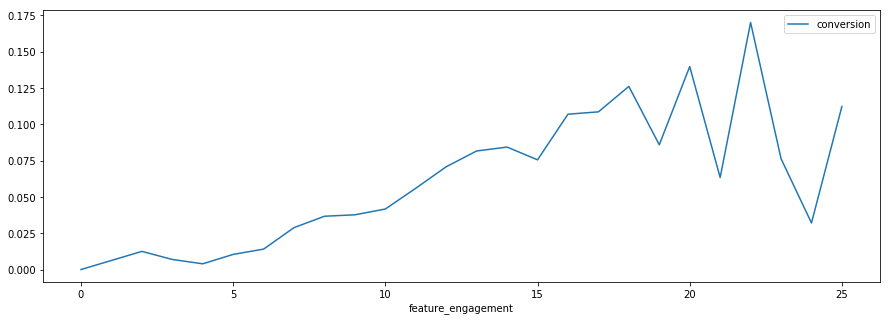

In [48]:
ax = avgs.groupby('feature_engagement')['conversion'].median().reset_index().plot(x='feature_engagement', figsize=(15,5))
ax.figure.savefig("feature_engagement_conversion.png")

# performance by specific features

In [60]:
org_avgs = perf[perf['conversion']!=np.inf].groupby('org')[['vol', 'count', 'pageviews', 'conversion']].mean().reset_index()
org_avgs = org_avgs.merge(orgs.drop('vol', axis=1), on='org')
org_avgs.head()

,org,vol,count,pageviews,conversion,users_created,logins,integrations,page_updates,widgets_created,...,source_mobilevt,source_sms,source_fb,source_givi,recurring,donorlogins,logins_six_months,logins_three_months,logins_one_months,engagement_sum
0,6,13097.242059,99.676471,795.529412,0.139747,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
1,9,0.204706,0.147059,1120.705882,0.000123,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0
2,13,7858.786176,67.176471,1659.617647,0.055358,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0
3,31,5258.405882,21.970588,333.117647,0.085382,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,12.0
4,33,1006.697353,2.911765,64.823529,0.049843,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,11.0


In [62]:
drop_cols = ['org', 'vol', 'count', 'pageviews', 'conversion', 'engagement_sum']

print("| Feature | Conversion Active | Conversion Inactive |")
print("|---------|-------------------|---------------------|")
for col in [c for c in org_avgs.columns if c not in drop_cols]:
    this_cohort = org_avgs[org_avgs[col]==1.0]
    not_this_cohort = org_avgs[org_avgs[col]==0.]
    print("| {} | {:.2f}% | {:.2f}% |".format(col, this_cohort['conversion'].median() * 100., not_this_cohort['conversion'].median() * 100.))

| Feature | Conversion Active | Conversion Inactive |
|---------|-------------------|---------------------|
| users_created | 4.17% | 2.67% |
| logins | 5.32% | 1.03% |
| integrations | 8.78% | 4.14% |
| page_updates | 3.92% | 4.67% |
| widgets_created | 8.74% | 4.14% |
| goals_saved | 8.78% | 4.14% |
| fundhub_builder_accessed | 8.74% | 4.14% |
| event_builder_accessed | 3.92% | 4.51% |
| form_builder_accessed | 4.52% | 4.15% |
| auctions | 10.71% | 4.14% |
| badges | 12.57% | 3.57% |
| thermometers | 4.78% | 4.03% |
| lists | 3.78% | 4.17% |
| smscampaigns | 3.74% | 4.17% |
| source_don_form | 4.21% | 2.40% |
| source_vt | 5.25% | 2.38% |
| source_p2p | 11.86% | 3.56% |
| source_kiosk | 12.18% | 3.97% |
| source_mobile | 4.98% | 3.07% |
| source_mobilevt | 6.95% | 3.69% |
| source_sms | 5.63% | 3.74% |
| source_fb | 7.40% | 3.96% |
| source_givi | 9.34% | 3.98% |
| recurring | 5.35% | 2.10% |
| donorlogins | 6.52% | 3.22% |
| logins_six_months | 5.52% | 1.40% |
| logins_three_months 

| Feature | Conversion Active | Conversion Inactive |
|---------|-------------------|---------------------|
| users_created | 4.17% | 2.67% |
| logins | 5.32% | 1.03% |
| integrations | 8.78% | 4.14% |
| page_updates | 3.92% | 4.67% |
| widgets_created | 8.74% | 4.14% |
| goals_saved | 8.78% | 4.14% |
| fundhub_builder_accessed | 8.74% | 4.14% |
| event_builder_accessed | 3.92% | 4.51% |
| form_builder_accessed | 4.52% | 4.15% |
| auctions | 10.71% | 4.14% |
| badges | 12.57% | 3.57% |
| thermometers | 4.78% | 4.03% |
| lists | 3.78% | 4.17% |
| smscampaigns | 3.74% | 4.17% |
| source_don_form | 4.21% | 2.40% |
| source_vt | 5.25% | 2.38% |
| source_p2p | 11.86% | 3.56% |
| source_kiosk | 12.18% | 3.97% |
| source_mobile | 4.98% | 3.07% |
| source_mobilevt | 6.95% | 3.69% |
| source_sms | 5.63% | 3.74% |
| source_fb | 7.40% | 3.96% |
| source_givi | 9.34% | 3.98% |
| recurring | 5.35% | 2.10% |
| donorlogins | 6.52% | 3.22% |
| logins_six_months | 5.52% | 1.40% |
| logins_three_months | 5.83% | 1.81% |
| logins_one_months | 6.32% | 2.25% |

In [66]:
drop_cols = ['org', 'vol', 'count', 'pageviews', 'conversion', 'engagement_sum']

print("| Feature | Pageviews Active | Pageviews Inactive |")
print("|---------|-------------------|---------------------|")
for col in [c for c in org_avgs.columns if c not in drop_cols]:
    this_cohort = org_avgs[org_avgs[col]==1.0]
    not_this_cohort = org_avgs[org_avgs[col]==0.]
    print("| {} | {:.2f} | {:.1f} |".format(col, this_cohort['pageviews'].median(), not_this_cohort['pageviews'].median()))

| Feature | Pageviews Active | Pageviews Inactive |
|---------|-------------------|---------------------|
| users_created | 111.85 | 13.0 |
| logins | 149.68 | 26.7 |
| integrations | 274.00 | 108.0 |
| page_updates | 106.93 | 115.5 |
| widgets_created | 285.40 | 107.3 |
| goals_saved | 274.00 | 108.0 |
| fundhub_builder_accessed | 272.00 | 108.0 |
| event_builder_accessed | 107.29 | 113.0 |
| form_builder_accessed | 273.33 | 101.9 |
| auctions | 273.33 | 106.9 |
| badges | 251.41 | 96.4 |
| thermometers | 232.26 | 82.3 |
| lists | 178.66 | 108.8 |
| smscampaigns | 198.65 | 108.8 |
| source_don_form | 115.89 | 18.0 |
| source_vt | 155.69 | 51.1 |
| source_p2p | 239.81 | 95.7 |
| source_kiosk | 199.24 | 105.3 |
| source_mobile | 206.29 | 47.3 |
| source_mobilevt | 270.90 | 90.9 |
| source_sms | 185.10 | 89.2 |
| source_fb | 283.18 | 100.6 |
| source_givi | 210.20 | 104.6 |
| recurring | 161.69 | 46.6 |
| donorlogins | 278.77 | 72.0 |
| logins_six_months | 163.67 | 34.7 |
| logins_three_

| Feature | Pageviews Active | Pageviews Inactive |
|---------|-------------------|---------------------|
| users_created | 111.85 | 13.0 |
| logins | 149.68 | 26.7 |
| integrations | 274.00 | 108.0 |
| page_updates | 106.93 | 115.5 |
| widgets_created | 285.40 | 107.3 |
| goals_saved | 274.00 | 108.0 |
| fundhub_builder_accessed | 272.00 | 108.0 |
| event_builder_accessed | 107.29 | 113.0 |
| form_builder_accessed | 273.33 | 101.9 |
| auctions | 273.33 | 106.9 |
| badges | 251.41 | 96.4 |
| thermometers | 232.26 | 82.3 |
| lists | 178.66 | 108.8 |
| smscampaigns | 198.65 | 108.8 |
| source_don_form | 115.89 | 18.0 |
| source_vt | 155.69 | 51.1 |
| source_p2p | 239.81 | 95.7 |
| source_kiosk | 199.24 | 105.3 |
| source_mobile | 206.29 | 47.3 |
| source_mobilevt | 270.90 | 90.9 |
| source_sms | 185.10 | 89.2 |
| source_fb | 283.18 | 100.6 |
| source_givi | 210.20 | 104.6 |
| recurring | 161.69 | 46.6 |
| donorlogins | 278.77 | 72.0 |
| logins_six_months | 163.67 | 34.7 |
| logins_three_months | 190.67 | 39.0 |
| logins_one_months | 234.31 | 45.1 |